In [ ]:
### Using my developed metrics for nucleiDysmorphia analysis
### Created by Madeline E Melzer on 20230726, Last Edit by Madeline E Melzer on 20231221

In [1]:
import cv2
import glob
import numpy as np
import pandas as pd
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import skimage
import cellpose
import imagecodecs
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from urllib.parse import urlparse
from cellpose import models, core
from cellpose.io import logger_setup
from PIL import Image
from os import listdir
from os.path import isfile, join
from skimage import measure
import matplotlib.pyplot as plt
logger_setup();
import skimage.io as io
import math
import seaborn as sns
import re

>>> GPU activated? 0
2023-12-21 07:47:55,642 [INFO] WRITING LOG OUTPUT TO /Users/mem3579/.cellpose/run.log
2023-12-21 07:47:55,642 [INFO] 
cellpose version: 	2.2.3 
platform:       	darwin 
python version: 	3.9.6 
torch version:  	2.1.1


In [2]:
# pre-processing

def pre_process(file):
    masks = Image.open(file)
    masksArray = np.array(masks)

    if np.all(masksArray == 0):
        print(f"Skipping {file} because it has no mask signal")
        return None, None, None

    # Get the unique labels in the masksArray
    labels = np.unique(masksArray)
    # Remove 0 from labels as it corresponds to the background
    labels = labels[labels != 0]

    # Initialize outlines as zeros array of same shape as masksArray
    outlines = np.zeros_like(masksArray)

    for label in labels:
        # Get binary mask for the current label
        binary_mask = (masksArray == label).astype(np.uint8)
        # Get contours for the binary mask
        contours = measure.find_contours(binary_mask, 0.5)
        # Draw contours on the outlines array
        for contour in contours:
            contour = np.around(contour).astype(int)
            outlines[contour[:, 0], contour[:, 1]] = 1

    #minkowskiDimension = getminkowskidimension(masks)
    contours = measure.find_contours(masksArray, 0.5)
    outlines = outlines.astype(np.uint8)

    return masksArray, outlines, contours

In [3]:
def rotate_point(x, y, angle):
    """Rotate a point counterclockwise by a given angle around the origin."""
    new_x = x * np.cos(angle) + y * np.sin(angle)
    new_y = -x * np.sin(angle) + y * np.cos(angle)
    return new_x, new_y

def calculate_distances(binary_mask_for_label, df_props, label):
    # Find the coordinates of the outlines in binary_mask_for_label
    outlines = measure.find_contours(binary_mask_for_label, 0.5)
    # Assuming there's only one outline for the label, if not, you might need to loop through multiple outlines
    if outlines:
        outline = outlines[0]
        outline = np.round(outline).astype(int)
        coord = (outline[:, 0], outline[:, 1])
    else:
        return pd.DataFrame()

    distance_data = []

    # Filter df_props for the specified label
    df_props_label = df_props[df_props['label'] == label]

    for i in range(len(coord[0])):
        outline_x = coord[1][i]
        outline_y = coord[0][i]

        for index, row in df_props_label.iterrows():
            centroid_x = row['centroid-1']
            centroid_y = row['centroid-0']
            semi_major = row['major_axis_length']/2
            semi_minor = row['minor_axis_length']/2
            orientation = row['orientation']

            # Rotate outline point and centroid by the negative of the orientation angle
            rotated_outline_x, rotated_outline_y = rotate_point(outline_x - centroid_x, outline_y - centroid_y, -orientation)
            rotated_centroid_x, rotated_centroid_y = 0, 0  # The centroid becomes the origin after rotation

            r = math.dist((rotated_outline_y, rotated_outline_x), (rotated_centroid_y, rotated_centroid_x))
            theta = math.atan2((rotated_outline_y - rotated_centroid_y), (rotated_outline_x - rotated_centroid_x))

            r_norm = (semi_major*semi_minor)/(math.sqrt(((semi_major**2) * (math.sin(theta))**2) + ((semi_minor**2) * (math.cos(theta))**2)))
            r_rms = math.sqrt(abs((r**2)-(r_norm**2)))

            distance_data.append([
                row['label'], centroid_x, centroid_y, outline_x, outline_y, theta,
                r, r_norm, r_rms, row['major_axis_length'], row['minor_axis_length']
            ])

    df_distance = pd.DataFrame(distance_data, columns=[
        'label', 'centroid_x', 'centroid_y', 'outline_x', 'outline_y', 'theta',
        'r', 'r_norm', 'r_rms', 'major_axis_length', 'minor_axis_length'
    ])

    return df_distance


In [4]:
# root mean square average calculation

def calculate_rms_avgs(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]

    r_avgs = []
    rms_avgs = []
    r_diffs = []

    r_avg = df_distance_label['r'].mean()
    r_avgs.append(r_avg)

    rms_avg = df_distance_label['r_rms'].mean()
    rms_avgs.append(rms_avg)

    for i, row in df_distance_label.iterrows():
        r_diff = row['r'] - r_avg
        r_diffs.append(r_diff)

    return r_avgs, rms_avgs, r_diffs

In [5]:
# x-intercepts calculation (nuclear irregularity metric 1)

def calculate_x_intercepts(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]

    df_bin_avg = pd.DataFrame()

    df_label = df_distance_label.copy()
    df_label['theta_bin'] = pd.cut(df_label['theta'], np.arange(-np.pi, np.pi, 0.1), right=True)
    grouped = df_label.groupby('theta_bin')

    for theta_bin, group in grouped:
        r_diff_bin = group['r_diff'].mean()
        new_data = {'label': label, 'bin': theta_bin, 'r_diff_bin': r_diff_bin}
        df_bin_avg = pd.concat([df_bin_avg, pd.DataFrame([new_data])], ignore_index=True)

    df_bin_avg['sign_change'] = np.sign(df_bin_avg['r_diff_bin']).diff().ne(0).astype(int)
    df_intercept = df_bin_avg[df_bin_avg['sign_change'] != 0]

    return df_bin_avg, df_intercept

In [6]:
# subsampling for root mean squared difference (nuclear irregularity metric 2)

def calculate_rms_diff(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]
    subsample_size = 50
    df_rmssub = pd.DataFrame(columns=['label', 'rms'])

    df_label = df_distance_label.sort_values('theta')
    num_points = len(df_label)

    if num_points > subsample_size:
        theta_points = np.arange(num_points)[::int(num_points/subsample_size)]
        rms_values = df_label.iloc[theta_points]['r_rms'].values
        rms_sub_avg = np.average(rms_values)
    else:
        rms_sub_avg = np.nan

    new_row = pd.DataFrame({'rms': [rms_sub_avg]})
    df_rmssub = pd.concat([df_rmssub, new_row], ignore_index=True)

    return df_rmssub

In [7]:
# concavity count calculation (nuclear irregularity metric 3)

def calculate_concavity_ct(df_distance, label):
    df_distance_label = df_distance[df_distance['label'] == label]
    concavity_ct = 0
    theta_vals = np.unique(df_distance_label['theta'])

    for theta in theta_vals:
        r_vals = df_distance_label.loc[
            (df_distance_label['theta'] >= theta-0.002) &
            (df_distance_label['theta'] <= theta+0.002), 'r'].unique()

        if len(r_vals) > 1:
            concavity_ct += 1

    return [concavity_ct]

In [ ]:
### post-processing functions for getting image-level information about the nuclei

# Extract age
def extract_age(filename):
    if re.search(r'52week|52wk|1year|1yo', filename):
        return 52
    elif re.search(r'24week|6mo', filename):
        return 24
    elif re.search(r'12week|12wk', filename):
        return 12
    elif re.search(r'7wk', filename):
        return 7
    else:
        return None

# Extract sex
def extract_sex(filename):
    match = re.search(r'(Male|Female)', filename)
    return match.group(1) if match else None

# Extract animal
def extract_animal(filename):
    match = re.search(r'(Male|Female)(\d+)', filename)
    return match.group(2) if match else None

# Extract location
def extract_location(filename):
    match = re.search(r'(Arch|Desc)', filename)
    return match.group(1) if match else None

# Extract image number
def extract_image_number(filename):
    match = re.search(r'60x_(\d)', filename)
    return match.group(1) if match else None

In [11]:
## main function

def main(files):
    dfResult = pd.DataFrame()

    for file in files:
        print(file)
        labeled_image, outlines, contours = pre_process(file)

        if labeled_image is None:
            continue

        #labeled_image = measure.label(masksArray)

        props = measure.regionprops_table(labeled_image, properties=['label',
                                                                'area',
                                                                'perimeter',
                                                                'centroid',
                                                                'major_axis_length',
                                                                'minor_axis_length',
                                                                'eccentricity',
                                                                'solidity',
                                                                'euler_number',
                                                                'equivalent_diameter_area',
                                                                'area_bbox',
                                                                'area_convex',
                                                                'area_filled',
                                                                'extent',
                                                                'feret_diameter_max',
                                                                'perimeter_crofton',
                                                                'orientation'])

        df_props = pd.DataFrame(props)
        df_props.insert(0, 'file', file)

        df_props['centroid-0'] += 0.5
        df_props['centroid-1'] += 0.5

        df_results = []

        for label in np.unique(labeled_image):
            if label == 0:
                continue

            # Generate a binary mask for the current label
            binary_mask_for_label = (labeled_image == label).astype(np.uint8)

            # Compute the Minkowski dimension for this binary mask
            minkowskiDimension_label = getminkowskidimension(binary_mask_for_label)

            df_props_label = df_props[df_props['label'] == label].copy()

            # Pass the computed Minkowski dimension to the calculate_rms_avgs function
            df_distance = calculate_distances(binary_mask_for_label, df_props_label, label)

            r_avgs, rms_avgs, r_diffs = calculate_rms_avgs(df_distance, label)

            #convex_areas = compute_convex_area(binary_mask_for_label)

            df_distance['r_diff'] = r_diffs

            df_bin_avg, df_intercept = calculate_x_intercepts(df_distance, label)
            df_rmssub = calculate_rms_diff(df_distance, label)
            concav = calculate_concavity_ct(df_distance, label)

            df_props_label['r_avg'] = r_avgs
            df_props_label['rms_avg'] = rms_avgs
            df_props_label['minkowskiDimension'] = minkowskiDimension_label
            df_props_label['x_intercepts'] = df_intercept.groupby('label').size().tolist()
            df_props_label['rms_subsampled'] = df_rmssub['rms'].values.tolist()
            df_props_label['concavity_ct'] = list(concav)
            #df_props_label['convex_area'] = convex_areas

            df_props_label['circularity'] = 4 * np.pi * df_props_label.loc[:, 'area'] / (df_props_label.loc[:, 'perimeter'] ** 2)
            df_props_label['compactness'] = df_props_label['area'] / df_props_label['perimeter']**2
            df_props_label['roundness'] = df_props_label['area'] / (math.pi * (df_props_label['perimeter'] / (2*math.pi))**2)
            df_props_label['convexity'] = df_props_label['perimeter'] / df_props_label['area_convex']
            df_props_label['aspect_ratio'] = df_props_label['major_axis_length'] / df_props_label['minor_axis_length']
            df_props_label['form_factor'] = df_props_label['area'] / df_props_label['equivalent_diameter_area']**2 #currently not working for some reason??????????????

            df_results.append(df_props_label)

            #print(df_results)

        dfResult = pd.concat([dfResult, *df_results])

    return dfResult


In [ ]:
# execution
dataPath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/20231206/segmented/filteredPeriphery/"
savePath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/output_metrics/"

files = glob.glob(f"{dataPath}/*.tif")
dfResult = main(files)

#post-processing for age timecourse nuclei
dfResult['age'] = dfResult['file'].apply(extract_age)
dfResult['sex'] = dfResult['file'].apply(extract_sex)
dfResult['animal'] = dfResult['file'].apply(extract_animal)
dfResult['location'] = dfResult['file'].apply(extract_location)
dfResult['imageNumber'] = dfResult['file'].apply(extract_image_number)

dfResult.to_csv(os.path.join(savePath, "20231221_newAges.csv"), index = False)

In [22]:
## adding csv files together for ages

fileOne = pd.read_csv(os.path.join(savePath, "20231107_allAges.csv"))
fileTwo = pd.read_csv(os.path.join(savePath, "20231221_newAges.csv"))

combined_data = pd.concat([fileOne, fileTwo])

combined_data.to_csv("/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/output_metrics/20231221_allAges.csv")

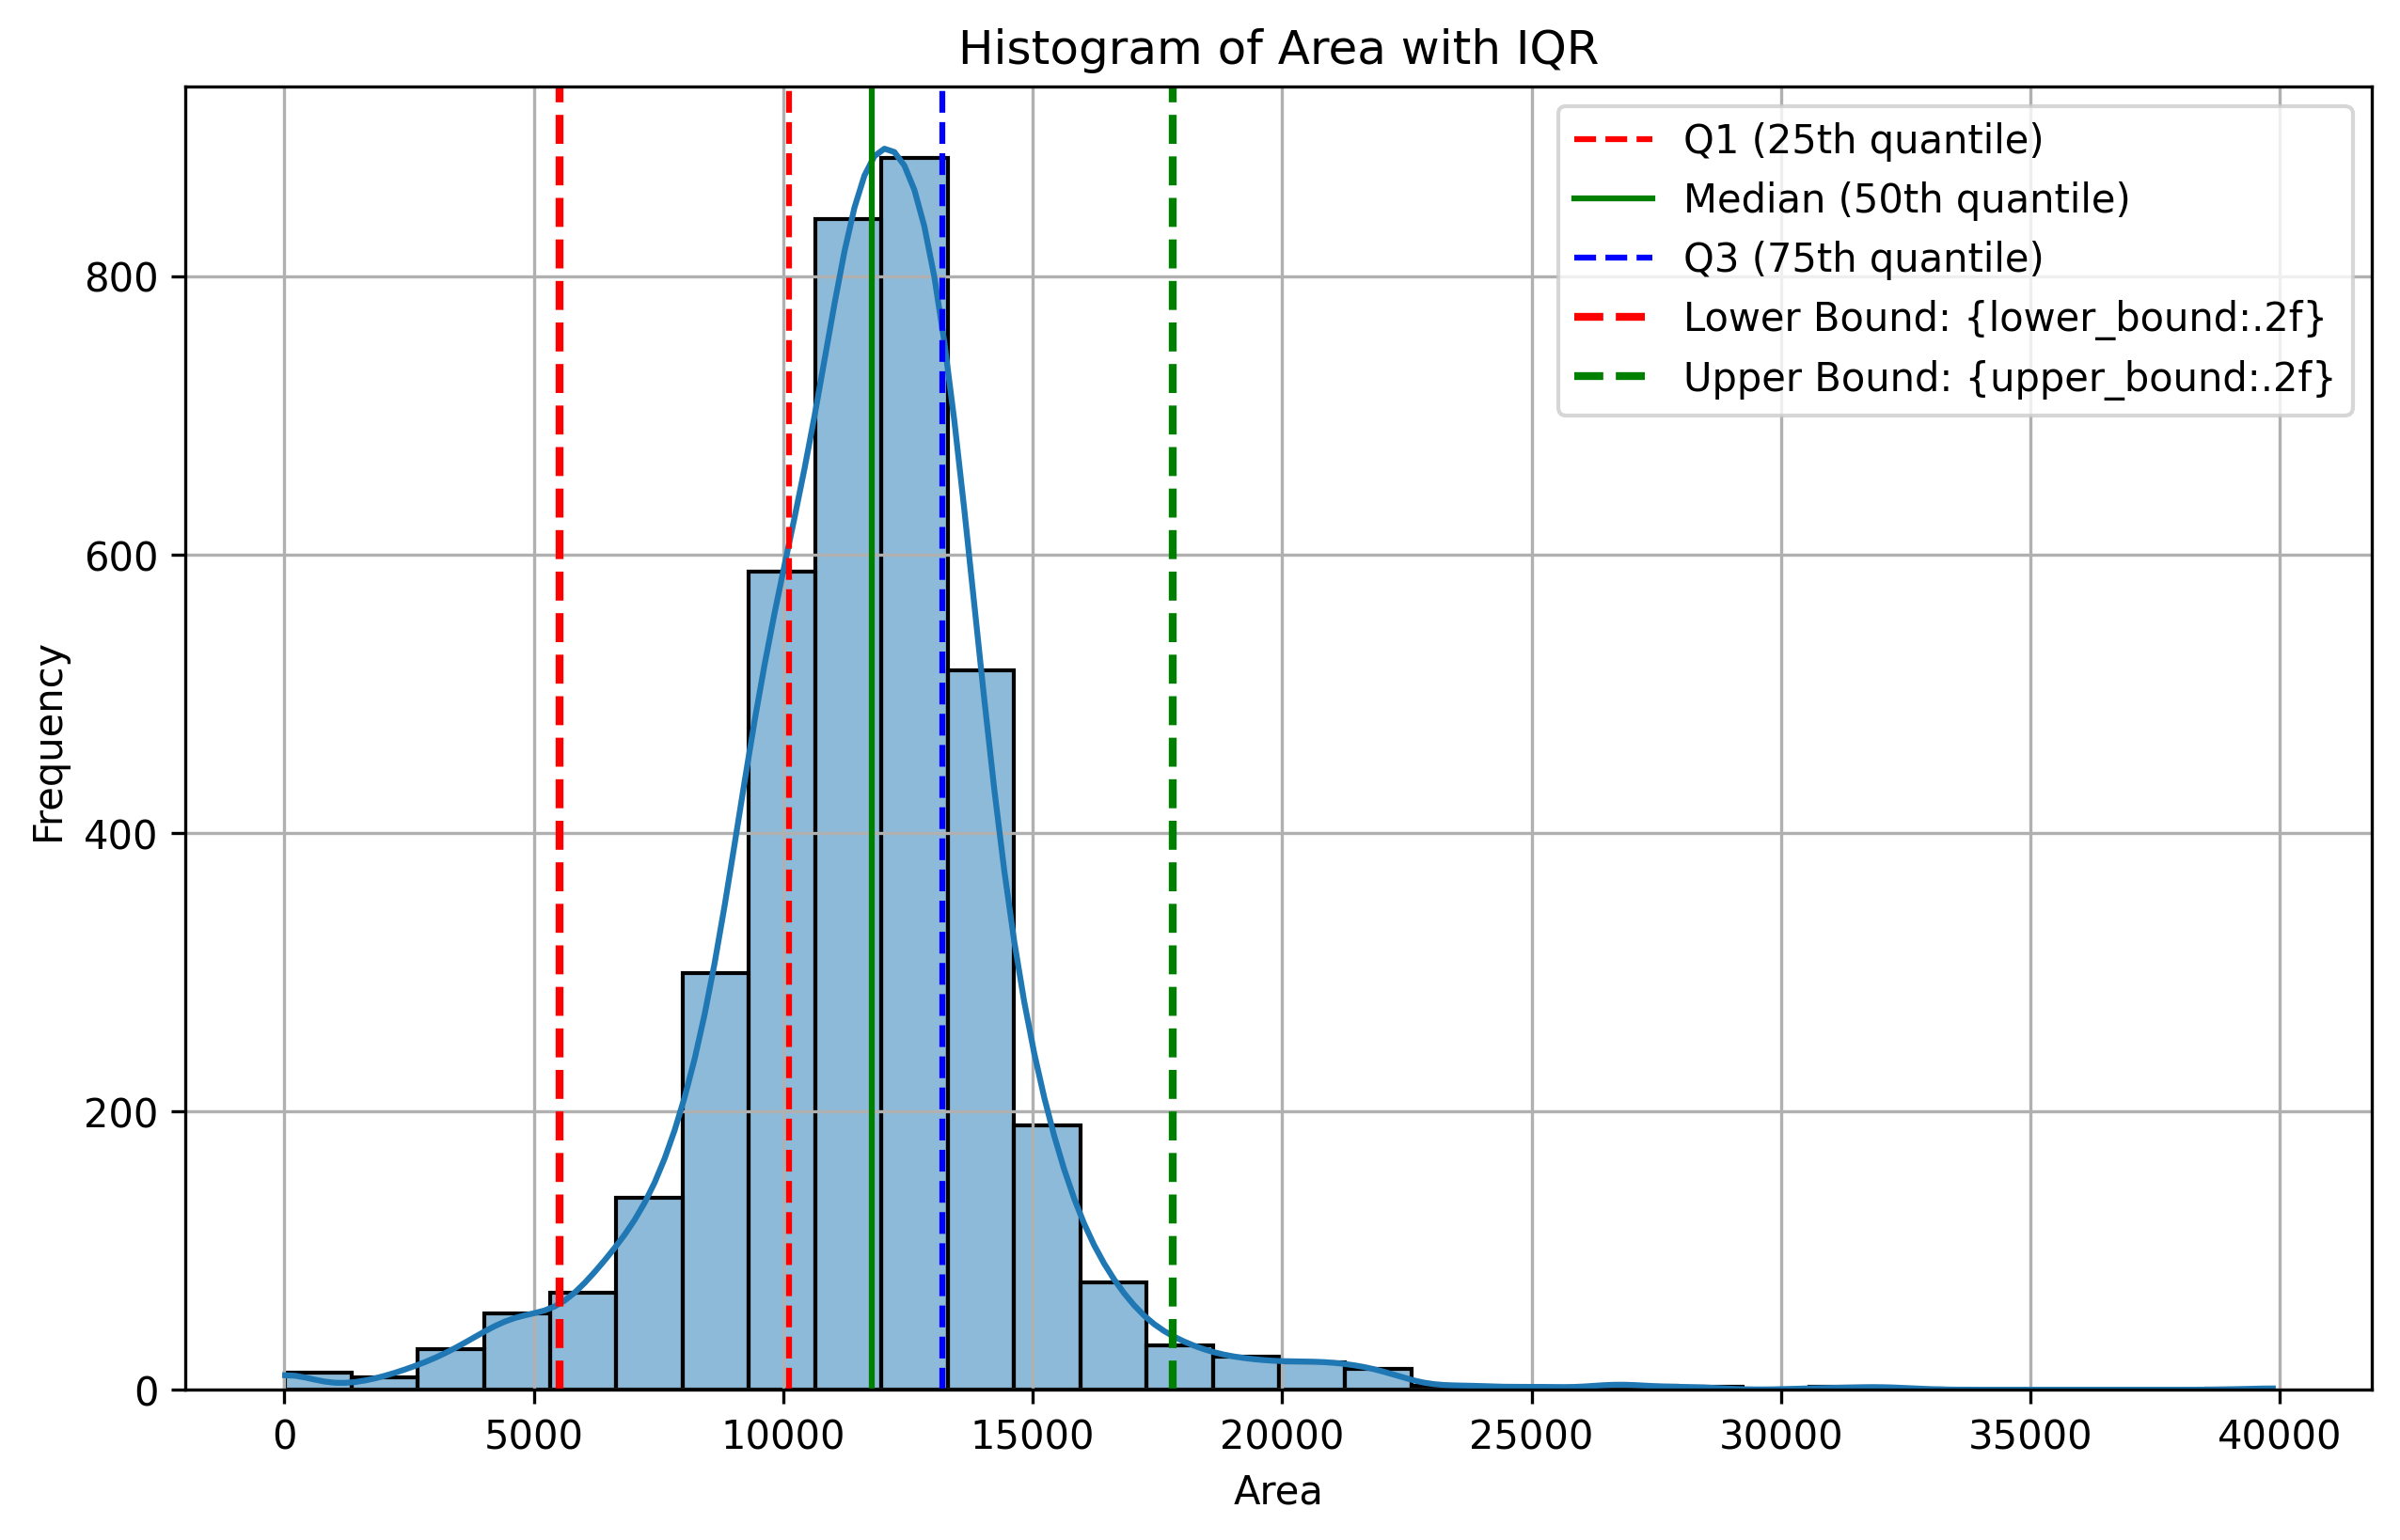

lower_bound =  5509.125
upper_bound =  17812.125


In [23]:
## Checking up on the Area (output bounds will be used as cutoffs for outliers in metricPlots.R)

#dfResult = pd.read_csv("/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/output_metrics/20231221_allAges.csv")

Q1 = dfResult['area'].quantile(0.25)
Q3 = dfResult['area'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Plotting histogram for the 'area' column in dfResult
plt.figure(figsize=(10, 6))
sns.histplot(dfResult['area'], kde=True, bins=30)
plt.axvline(Q1, color='r', linestyle='--', label='Q1 (25th quantile)')
plt.axvline(dfResult['area'].median(), color='g', linestyle='-', label='Median (50th quantile)')
plt.axvline(Q3, color='b', linestyle='--', label='Q3 (75th quantile)')
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f"Lower Bound: {{lower_bound:.2f}}")
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label=f"Upper Bound: {{upper_bound:.2f}}")
plt.legend()
plt.title('Histogram of Area with IQR')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("lower_bound = ", lower_bound)
print("upper_bound = ", upper_bound)